In [42]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *

In [43]:
df = pd.read_csv("./DATA/Epilepsy/data.csv")

In [44]:
num_columns = len(df.columns)
print(len(df.index), num_columns)

11500 180


In [45]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def Oversample(data, labels):
    zeros = []
    ones = []
    for (index, label) in enumerate(labels):
        if label == 0:
            zeros.append(data[index])
        else:
            ones.append(data[index])

    zeros, ones = np.array(zeros), np.array(ones)
    ids = np.arange(len(ones))
    choices = np.random.choice(ids, len(zeros)) #choose entries from so that number of ones and zeroes are the same 

    res_ones_features = ones[choices]
    res_ones_labels = np.ones(len(res_ones_features))

    resampled_features = np.concatenate([res_ones_features, zeros], axis=0)
    resampled_labels = np.concatenate([res_ones_labels, np.zeros(len(zeros))], axis=0)

    return unison_shuffled_copies(resampled_features, resampled_labels)
        

In [46]:
df.head() #each row represents one second

,xx,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [47]:
df = df.sample(frac=1) #shuffle dataset
data = df.drop(['y', 'xx'], axis=1).to_numpy()
labels = df['y'].to_numpy()

count= 0
#map labels to binary - class 1 has epilepsy only. so class 1 for yes epilepsy, 0 for no
for (i,l) in enumerate(labels):
    if l != 1:
        labels[i] = 0
        count+=1
all_labels = list(set(df['y'].unique().tolist()))
print(all_labels)
print(count)

[0, 1]
9200


In [48]:
total = len(df.index)
num_zeroes = count
num_ones = total - num_zeroes
print(num_zeroes, num_ones)
zero_weight = (1/num_zeroes)*total/2
one_weight = (1/num_ones)*total/2
class_weight = {0: zero_weight, 1: one_weight}
print(class_weight)

9200 2300
{0: 0.625, 1: 2.5}


In [49]:
data, labels = Oversample(data, labels)

In [50]:
norm = np.linalg.norm(data)
data = data/norm

In [51]:
assert(len(data) == len(labels))
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])
train_labels, validate_labels, test_labels = np.split(labels, [int(.6*len(labels)), int(.8*len(labels))])

In [52]:
print(train.shape, validate.shape, test.shape)

(11040, 178) (3680, 178) (3680, 178)


In [53]:
TIMESTEPS = 1
def Reshape(input):
    size, features = input.shape
    return input.reshape(size, TIMESTEPS, features)
train, validate, test = Reshape(train), Reshape(validate), Reshape(test)

In [54]:
EPOCHS = 30
BATCH_SIZE = 256
INPUT_SHAPE = (TIMESTEPS, num_columns-2)
DROPOUT = 0.1

In [55]:
def Model():
    input = layers.Input(shape=INPUT_SHAPE)
    cell = layers.LSTMCell(4, dropout=DROPOUT)
    rnn = layers.RNN(cell)(input)
    # fc1 = layers.Dense(128, activation='relu')(rnn)
    output = layers.Dense(1, activation='sigmoid')(rnn)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
model = Model()
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 178)]          0         
_________________________________________________________________
rnn_1 (RNN)                  (None, 4)                 2928      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-7),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(train, train_labels, 
epochs=EPOCHS, 
validation_data=(validate, validate_labels), 
batch_size=BATCH_SIZE, 
verbose=2, 
callbacks=[callback],
# class_weight=class_weight,
shuffle=True)

Epoch 1/30
44/44 - 1s - loss: 0.7244 - accuracy: 0.5250 - val_loss: 0.7180 - val_accuracy: 0.5500
Epoch 2/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.5524 - val_loss: 0.7180 - val_accuracy: 0.5929
Epoch 3/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.5872 - val_loss: 0.7180 - val_accuracy: 0.6196
Epoch 4/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.6099 - val_loss: 0.7180 - val_accuracy: 0.6345
Epoch 5/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.6284 - val_loss: 0.7180 - val_accuracy: 0.6484
Epoch 6/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.6409 - val_loss: 0.7180 - val_accuracy: 0.6565
Epoch 7/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.6437 - val_loss: 0.7180 - val_accuracy: 0.6554
Epoch 8/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.6573 - val_loss: 0.7180 - val_accuracy: 0.6557
Epoch 9/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.6593 - val_loss: 0.7180 - val_accuracy: 0.6587
Epoch 10/30
44/44 - 0s - loss: 0.7244 - accuracy: 0.6578 - val_loss: 0.7180 - val_accuracy: 0.6576
Epoch 11/30
44/44 -

In [58]:
# model.save("./Models/Epilepsy_LSTM1.h5")

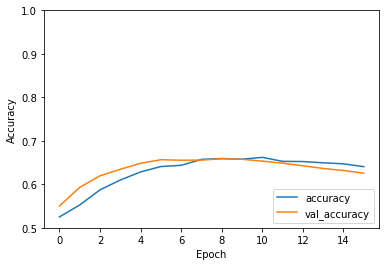

In [59]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [60]:
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)

115/115 - 0s - loss: 0.7291 - accuracy: 0.6497


In [61]:
test_labels[:50]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.])

In [62]:
# prediction = model.predict(np.expand_dims(test[0], axis=0))
prediction = model.predict(test)
print(prediction.shape)
for p in prediction[:50]:
    print(p)
    # print(np.argmax(prediction))

(3680, 1)
[0.49997887]
[0.50007594]
[0.49985096]
[0.49997902]
[0.49998242]
[0.5000401]
[0.49986297]
[0.49997956]
[0.4999705]
[0.49997553]
[0.49996936]
[0.49989414]
[0.49997133]
[0.49996522]
[0.50004834]
[0.49997246]
[0.49998215]
[0.49997345]
[0.4999412]
[0.49996835]
[0.49998412]
[0.49997512]
[0.4999685]
[0.5000815]
[0.49997362]
[0.50001305]
[0.5000597]
[0.49997377]
[0.49996188]
[0.5000004]
[0.49996528]
[0.4999874]
[0.49997354]
[0.49996403]
[0.49997342]
[0.4999663]
[0.49997443]
[0.49989957]
[0.5000393]
[0.4999645]
[0.4999452]
[0.49997345]
[0.4999937]
[0.4999804]
[0.4999797]
[0.49997842]
[0.5000706]
[0.49997923]
[0.4999471]
[0.49997738]
